In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#!pip3 install -U git+https://github.com/PYFTS/pyFTS
#!pip3 install SimpSOM
from keras.models import Model
from keras.layers import Dense, Input
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from pyFTS.benchmarks import Measures
import statistics
from pyFTS.common.Util import persist_obj, load_obj
from pyFTS.models.multivariate import common, variable, wmvfts
from pyFTS.partitioners import Grid
from pyFTS.common import Membership
import math
import pyFTS
import datetime
from pyFTS.common import Util

## Aux functions

In [2]:
def sample_first_prows(data, perc=0.75):
    return data.head(int(len(data)*(perc)))

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## Dataset Energy Appliances

In [4]:
df = pd.read_csv('energydata_complete.csv')
data = df.drop(labels=['date','rv1','rv2'], axis=1)
data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9


In [5]:
values = data.values
values

array([[ 60.        ,  30.        ,  19.89      , ...,   7.        ,
         63.        ,   5.3       ],
       [ 60.        ,  30.        ,  19.89      , ...,   6.66666667,
         59.16666667,   5.2       ],
       [ 50.        ,  30.        ,  19.89      , ...,   6.33333333,
         55.33333333,   5.1       ],
       ...,
       [270.        ,  10.        ,  25.5       , ...,   3.66666667,
         25.33333333,  13.26666667],
       [420.        ,  10.        ,  25.5       , ...,   3.83333333,
         26.16666667,  13.23333333],
       [430.        ,  10.        ,  25.5       , ...,   4.        ,
         27.        ,  13.2       ]])

### Dataset Energy Appliances: columns

In [6]:
cols = data.columns
list_cols = list(cols)
list_cols.append('Appliances_t+1')
print(list_cols)

['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'Appliances_t+1']


### Dataset Energy Appliance: Preprocessing, Lag = 1, t+1

In [7]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var24(t-1),var25(t-1),var26(t-1),var1(t)
1,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,60.0
2,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,50.0
3,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,50.0
4,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,60.0
5,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,50.0


In [8]:
data = pd.DataFrame(reframed.values,columns=list_cols)
data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Appliances_t+1
0,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,60.0
1,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,50.0
2,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,50.0
3,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,60.0
4,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,50.0


In [9]:
    
from sklearn.model_selection import train_test_split 
X = data.loc[:,'Appliances' :'Tdewpoint']
Y = data['Appliances_t+1']
X_train, X_test, y_train, y_test = train_test_split(X,Y,train_size=0.75, test_size=0.25, shuffle=False)
y_test = y_test.reset_index()
y_test.pop('index')

0       14800
1       14801
2       14802
3       14803
4       14804
        ...  
4929    19729
4930    19730
4931    19731
4932    19732
4933    19733
Name: index, Length: 4934, dtype: int64

In [13]:
input_layers = 26
output_layers = 2
input_layer = Input(shape=(input_layers, ))
encoder_layer_1 = Dense(14, activation="softsign",activity_regularizer=regularizers.l1(10e-5), kernel_initializer='normal')(input_layer)
encoder_layer_2 = Dense(output_layers, activation="softsign", kernel_initializer='normal')(encoder_layer_1)
decoder_layer_1 = Dense(14, activation="softsign",activity_regularizer=regularizers.l1(10e-5), kernel_initializer='normal')(encoder_layer_2)
decoder_layer_2 = Dense(input_layers, activation="softsign", kernel_initializer='normal')(decoder_layer_1)
autoencoder = Model(input_layer, decoder_layer_2)
autoencoder.compile(optimizer = 'adagrad', loss='mse')

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
autoencoder.fit(x=X_train, y=X_train, epochs=50, verbose=0, batch_size=40)
encoder_model = Model(inputs=input_layer, outputs=encoder_layer_2)
encoded_train = pd.DataFrame(encoder_model.predict(X_train))
encoded_train.columns = ['factor_1', 'factor_2']
encoded_train = encoded_train.join(y_train)


VX1= variable.Variable("factor_1", data_label="factor_1", partitioner = Grid.GridPartitioner, npart=50,     data=encoded_train )
VX2= variable.Variable("factor_2", data_label="factor_2", partitioner = Grid.GridPartitioner, npart=50,     data=encoded_train )
VY = variable.Variable("Appliances", data_label="Appliances_t+1", partitioner   = Grid.GridPartitioner, npart=50,   data=encoded_train ) 
fts_model = pyFTS.models.multivariate.wmvfts.WeightedMVFTS(explanatory_variables=[VX1, VX2, VY], target_variable=VY)
fts_model.fit(encoded_train)

In [14]:
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)

encoded_test = pd.DataFrame(encoder_model.predict(X_test))
encoded_test.columns = ['factor_1', 'factor_2']
encoded_test = encoded_test.join(y_test)

forecasts = fts_model.predict(encoded_test)

In [15]:
rmse = Measures.rmse(y_test['Appliances_t+1'],forecasts)
print (rmse)

20.02552762331472


In [24]:
fts_model.

1

In [26]:
print (y_test['Appliances_t+1'])
print (y_test['Appliances_t+1'].values[0:5])
print (forecasts[0:4])

0       280.0
1       320.0
2       360.0
3       210.0
4        90.0
        ...  
4929    100.0
4930     90.0
4931    270.0
4932    420.0
4933    430.0
Name: Appliances_t+1, Length: 4934, dtype: float64
[280. 320. 360. 210.  90.]
[279.8754835068554, 352.98499951598785, 228.82063974735365, 195.91332241803823]


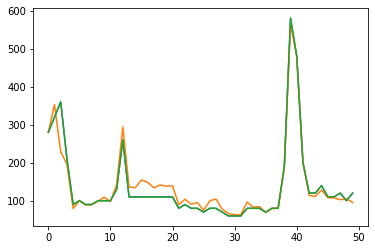

In [24]:
plt.plot(y_test.values[0:50])
plt.plot(forecasts[0:50])
plt.plot(y_test['Appliances_t+1'][0:50])